In [1]:
import tess_cpm
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
import lightkurve as lk

In [2]:
plt.rcParams['figure.figsize'] = (14, 8)

In [3]:
# fits_file = "tpf/tess-s0001-4-1_64.525833_-63.615669_64x64_astrocut.fits"
# fits_file = "tess-s0002-4-2_83.272000_-69.508733_64x64_astrocut.fits"
tabby14_file = "ffi/tabby/tess-s0014-2-4_301.564386_44.456886_100x100_astrocut.fits"
tabby15_file = "ffi/tabby/tess-s0015-2-3_301.564386_44.456886_100x100_astrocut.fits"
tau_ceti_file = "ffi/tau_ceti/tess-s0003-1-2_26.017048_-15.937482_100x100_astrocut.fits"

In [4]:
tabby15_data = tess_cpm.TargetData(tabby15_file)
cpm = tess_cpm.CPM(tabby15_data)

WCS Info could not be retrieved
Removing 7 bad data points (out of 1197) using the TESS provided QUALITY array


In [5]:
cpm.set_target_exclusion_predictors(50, 50, exclusion_size=10)
# cpm.lsq(0.1)

Performing 10-fold cross validation.
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


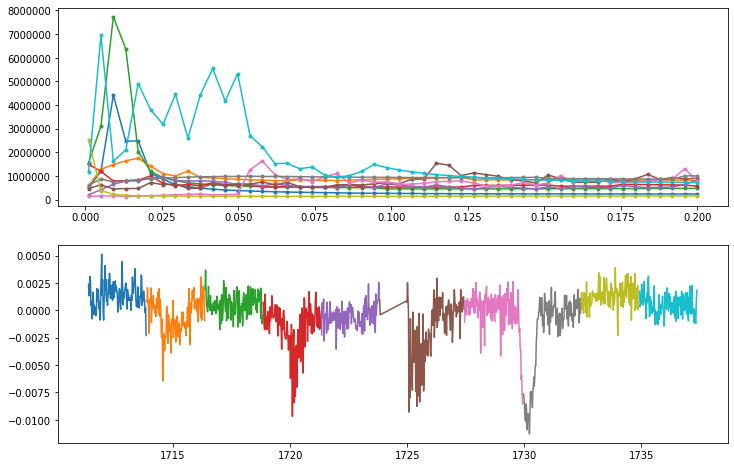

In [6]:
cdpps = cpm.get_hyperparameters(grid_size=50)

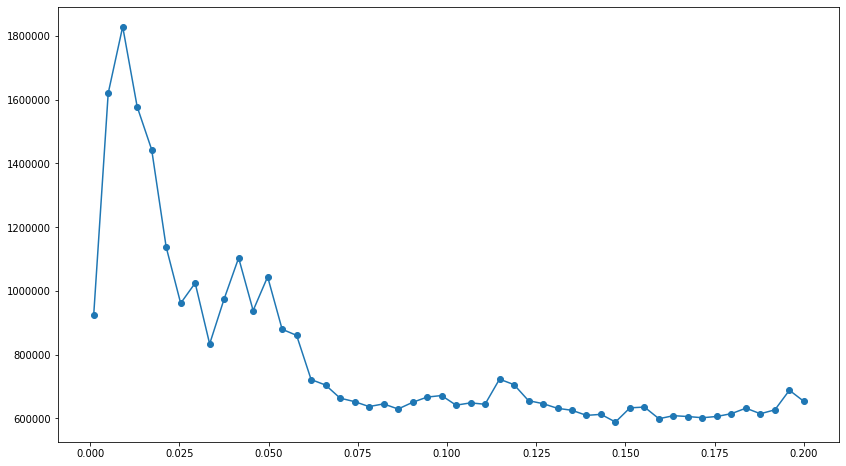

In [12]:
plt.plot(cdpps[0], np.mean(cdpps[1], axis=0), "o-")

In [10]:
cpm.lsq(1e5, rescale=False)
# predictions = cpm.get_unscaled_predictions()

Calculating parameters using unscaled values.


[array([1067.72588962, 1065.70472408, 1066.705572  , ..., 1088.65524122,
        1079.08263186, 1073.00662847]),
 array([ 0.14154202, -0.46534419,  0.85436453, ...,  0.62161425,
         1.7686865 ,  1.93184809])]

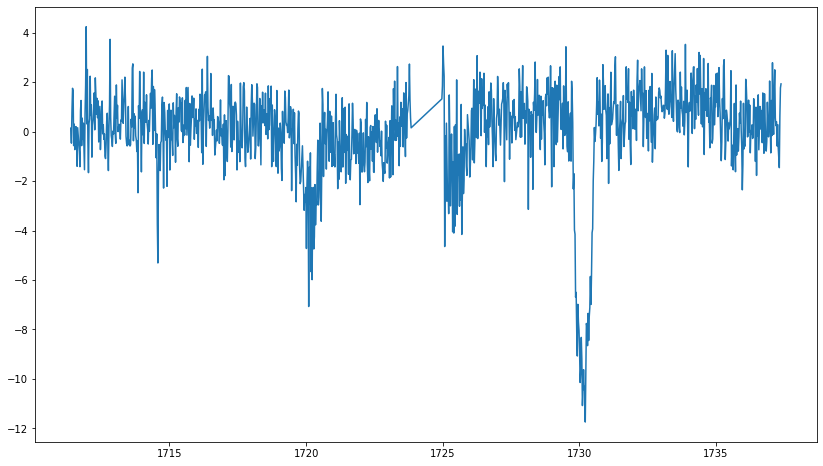

In [11]:
# plt.plot(cpm.time, cpm.centered_scaled_target_fluxes, color="black")
# plt.plot(cpm.time, cpm.all_prediction)
plt.plot(cpm.time, cpm.difference)
# plt.plot(cpm.time, cpm.target_fluxes - predictions[0] + np.mean(predictions[0]))
# plt.plot(cpm.time, cpm.target_fluxes)
# plt.plot(cpm.time, predictions[0])
# plt.plot(cpm.time, cpm.target_fluxes)


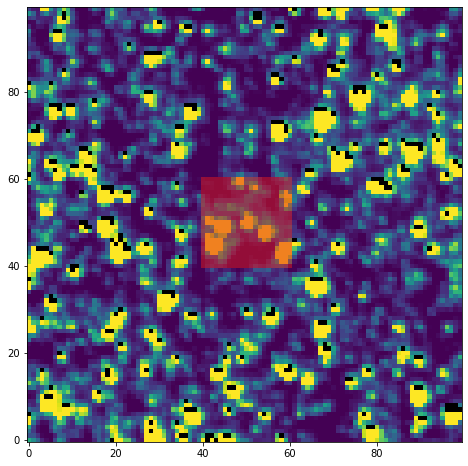

In [12]:
first_image = cpm.target_data.fluxes[0]
plt.imshow(first_image, origin='lower', vmin=np.percentile(first_image, 10), vmax=np.percentile(first_image, 90))
plt.imshow(np.ma.masked_where(cpm.mask_excluded_pixels == 0, cpm.mask_excluded_pixels), cmap="Set1", alpha=0.5, origin='lower')
plt.imshow(np.ma.masked_where(cpm.mask_predictor_pixels == 0, cpm.mask_predictor_pixels), cmap="binary_r", alpha=1.0, origin='lower')
# plt.colorbar()

In [48]:
cpm.mask_excluded_pixels[cpm.mask_excluded_pixels == 0] = np.nan
# cpm.mask_excluded_pixels
a = np.full(10, False)
a[a == False] = np.nan
# cpm.mask_excluded_pixels
a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [46]:
cpm.mask_excluded_pixels

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [ ]:
tb14 = tess_cpm.CPM(tabby14_file, remove_bad=True)
tb14.set_target(52, 50)
tb14.set_exclusion(10)
tb14.set_predictor_pixels(256, method="cosine_similarity")
tb14_prediction, tb14_baccor_lc = tb14.lsq(1)
tess_cpm.utils.summary_plot(tb14, 20)

In [ ]:
tb15 = tess_cpm.CPM(tabby15_file, remove_bad=True)
tb15.set_target(50, 50)
tb15.set_exclusion(10)
tb15.set_predictor_pixels(256, method="cosine_similarity")
# tb15_predictions, tb15_baccor_lcs = tb15.xval(1)
tb15_prediction, tb15_baccor_lc = tb15.lsq(0.1)
tb15_prediction
tess_cpm.utils.summary_plot(tb15, save=True)
# tb15_predictions

In [ ]:
rows = np.array([51, 50, 49])
cols = np.array([49, 50, 51])
lc_matrix = np.ones((rows.size, cols.size, 1190))

for row in rows:
    for col in cols:
        tb15 = tess_cpm.CPM(tabby15_file, remove_bad=True)
        tb15.set_target(row, col)
        tb15.set_exclusion(10)
        tb15.set_predictor_pixels(256, method="cosine_similarity")
        # tb15_predictions, tb15_baccor_lcs = tb15.xval(1)
        tb15_prediction, tb15_baccor_lc = tb15.lsq(0.1)
        lc_matrix[np.abs(row-51), col-49] = tb15_baccor_lc

In [ ]:
fig, axs = plt.subplots(rows.size, cols.size, sharex=True, sharey=True)
grid = np.indices((rows.size, cols.size))
for row in grid[0]:
    for col in grid[0]:
        ax = axs[row[0], col[0]]
        ax.plot(tb15.time, lc_matrix[row[0], col[0]], '-', color='black')
#         ymin, ymax = ax.get_ylim()
#         ymin, ymax
#         ax.vlines(tb15.dump_times, ymin=ymin, ymax=ymax, color="C3", alpha=0.8, label='Bad Points')
#         ax.set_ylim(ymin, ymax)
# fig.suptitle("Tabby's Star Sector 15 pixel lightcurves", fontsize=20);
# fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("Tabby's Star Sector 15 (Pixel Lightcurves)", fontsize=20, y=0.93);
plt.savefig("tabby_pixel_lc_sector15.png", dpi=300)

In [ ]:
# for lc_row in lc_matrix:
#     for lc in lc_row:
#         plt.plot(tb15.time, lc, '.-',alpha=0.7)
plt.show
aperture_lc = np.sum(lc_matrix, axis=(0, 1))
plt.plot(tb15.time, aperture_lc, '-', color="k")
plt.title("Tabby's Star Sector 15", fontsize=20)
plt.xlabel("Time - 2457000 [BJD]", fontsize=20)
plt.ylabel("Fractional Relative Flux", fontsize=20)
ax = plt.gca()
ymin, ymax = ax.get_ylim()
ymin, ymax
plt.vlines(tb15.dump_times, ymin=ymin, ymax=ymax, color="C3", alpha=0.8, label='Bad Points')
ax.set_ylim(ymin, ymax)
plt.savefig("tabby_sector15.png", dpi=300)

In [ ]:
tau_ceti = tess_cpm.CPM(tau_ceti_file, remove_bad=True)
tau_ceti.set_target(65, 50)
tau_ceti.set_exclusion(10)
tau_ceti.set_predictor_pixels(256, method="cosine_similarity")
tau_ceti.lsq(0.5)
tess_cpm.utils.summary_plot(tau_ceti, 20)

In [ ]:
cpm = tess_cpm.CPM(fits_file, remove_bad=True)

In [ ]:
cpm.set_poly_model(1, 4, 0.5)

In [ ]:
cpm.set_target_exclusion_predictors(32, 32)

In [ ]:
cpm.lsq(0.3, rescale=True, polynomials=True)

In [ ]:
tess_cpm.summary_plot(cpm, 10, subtract_polynomials=False)

In [ ]:
# plt.imshow(cpm.pixel_medians, origin="lower", vmin=np.percentile(cpm.pixel_medians, 10),
#          vmax=np.percentile(cpm.pixel_medians, 90))

In [ ]:
cpm.sigma_clip(2, iterations=3, subtract_polynomials=False)

In [ ]:
print(cpm.time.shape)
print(cpm.sigma_clipped_time.shape)

In [ ]:
plt.plot(cpm.sigma_clipped_time, cpm.sigma_clipped_fluxes, ".-")

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
# cpm.entire_image(0.1, rescale=True, polynomials=True)
diff = cpm.im_diff
upscaled_diff = cpm.pixel_medians*cpm.im_diff

fig, axes = plt.subplots(1, 3, figsize=(18, 18))

ims = []
for i in range(0, diff.shape[0], 10):
    im1 = axes[0].imshow(cpm.im_fluxes[i], origin="lower", animated=True,
                        vmin=np.percentile(cpm.im_fluxes[0], 10), vmax=np.percentile(cpm.im_fluxes[0], 90))
    im2 = axes[1].imshow(diff[i], origin="lower", animated=True,
                   vmin=np.percentile(diff, 1), vmax=np.percentile(diff, 99));
    im3 = axes[2].imshow(upscaled_diff[i], origin="lower", animated=True,
                   vmin=np.percentile(upscaled_diff, 1), vmax=np.percentile(upscaled_diff, 99));
    ims.append([im1, im2, im3]);
fig.colorbar(im1, ax=axes[0], fraction=0.046)
fig.colorbar(im2, ax=axes[1], fraction=0.046)
fig.colorbar(im3, ax=axes[2], fraction=0.046)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000);


ani.save("2018fhw.gif")
HTML(ani.to_jshtml())


In [ ]:
plt.figure(figsize=(18, 10))
# plt.plot(cpm.time, cpm.target_fluxes, '.')
plt.plot(cpm.time, (cpm.lsq_prediction+1)*np.median(cpm.target_fluxes), '.')
# plt.plot(cpm.time, (cpm.poly_prediction+1-cpm.poly_params[0])*np.median(cpm.target_fluxes), ".")
# plt.plot(cpm.time, (cpm.poly_prediction-cpm.poly_params[0]), ".")

plt.plot(cpm.time, (cpm.cpm_prediction+1+cpm.poly_params[0])*np.median(cpm.target_fluxes), ".")
# plt.plot(cpm.time, cpm.target_fluxes-(cpm.cpm_prediction+1+cpm.poly_params[0])*np.median(cpm.target_fluxes), ".")

In [ ]:
cpm.entire_image(0.5, polynomials=True)

In [ ]:
tess_cpm.summary_plot(cpm, 10)

In [ ]:
apt, apt_lc = cpm.difference_image_sap(cpm.cpm_regularization, 32, 32, 1, polynomials=True)

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(cpm.time, apt_lc)

# apt = apt.reshape(apt.shape[0], 9)
# for i in range(9):
#     plt.plot(cpm.time, apt[:, i])
plt.plot(cpm.time, apt_lc, ".", color="Red")

In [ ]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [ ]:
from astroquery.mast import Tesscut

In [ ]:
c = SkyCoord(64.525833, -63.615669, unit='deg')

In [ ]:
c.dec

In [ ]:
tesscut_test_download = Tesscut.download_cutouts(c)

In [ ]:
c = SkyCoord("5:33:05.28 -69:30:31.44", unit=(u.hourangle, u.deg))

In [ ]:
moa = Tesscut.download_cutouts(c, size=64, sector=2)

In [ ]:
fits_file = "./tess-s0002-4-2_83.272000_-69.508733_64x64_astrocut.fits"
c = tess_cpm.CPM(fits_file, remove_bad=True)
plt.subplot(projection=c.wcs_info)
plt.imshow(c.pixel_medians, vmin=np.percentile(c.pixel_medians, 0),
           vmax=np.percentile(c.pixel_medians, 99))

world = c.wcs_info.wcs_pix2world(32, 32, 0)
print(world)
print(c.wcs_info.wcs_world2pix(world[0], world[1], 0))

In [ ]:
c.set_target_exclusion_predictors(32, 32, exclusion=8)
c.set_poly_model(2, 4, 1.0)

In [ ]:
c.lsq(0.5, rescale=True, polynomials=True)

In [ ]:
tess_cpm.summary_plot(c, 10)

In [ ]:
# c.entire_image(0.5, rescale=True, polynomials=True)
# plt.plot(c.time, c.cpm_prediction, ".")
# plt.plot(c.time, c.poly_prediction, ".")
# plt.plot(c.time, c.cpm_prediction+c.poly_prediction, ".")
plt.plot(c.time, c.target_fluxes - (c.cpm_prediction+c.poly_prediction), '.')
plt.plot(c.time, c.target_fluxes - c.lsq_prediction, ".")

In [ ]:
# apt, apt_lc = c.difference_image_sap(32, 32, 2, exclusion=8, polynomials=True)
# print(apt.shape)
print(np.all((c.target_fluxes - c.cpm_prediction) == apt[:, 2, 2]))
plt.plot(c.time, c.target_fluxes - c.cpm_prediction)
plt.plot(c.time, apt[:, 2, 2])

In [ ]:
plt.figure(figsize=(15, 10))
for p in range(3):
    pixels = 2*p+1
    print(pixels**2)
    apt, apt_lc = c.difference_image_sap(32, 32, p, polynomials=True)
    plt.plot(c.time, apt_lc, ".", label="{}x{}".format(pixels, pixels))
plt.legend()

In [ ]:
plt.figure(figsize=(15 ,10))
apt = apt.reshape(apt.shape[0], 9)
for i in range(9):
    plt.plot(c.time, apt[:, i], label="{}".format(i))
# plt.plot(c.time, apt_lc, ".", color="Red")
# plt.legend()

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
c.entire_image(0.5, rescale=True, polynomials=True)
diff = c.im_diff

fig = plt.figure(figsize=(10, 10))

ims = []
for i in range(0, diff.shape[0], 10):
    im = plt.imshow(diff[i], origin="lower", animated=True,
                   vmin=np.percentile(diff, 1), vmax=np.percentile(diff, 100));
    ims.append([im]);
fig.colorbar(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000);

HTML(ani.to_jshtml())

In [ ]:
c.set_target_exclusion_predictors(55, 40)
c.lsq(0.3, polynomials=False)
tess_cpm.summary_plot(c, 10)

In [ ]:
c.set_target_exclusion_predictors(55, 40)
c.lsq(0.3, polynomials=True)
tess_cpm.summary_plot(c, 10)

In [ ]:
ap, lc = c.difference_image_sap(55, 40, 1)

In [ ]:
plt.figure(figsize=(15, 10))
ap = ap.reshape(ap.shape[0], 9)
for i in range(9):
    plt.plot(c.time, ap[:, i], '-')
plt.plot(c.time, lc)

In [ ]:
I = np.identity(10)
ll = np.repeat(2, 6)
mm = np.repeat(4, 4)
i = np.hstack((ll, mm))
i

In [ ]:
i*I

In [ ]:
2*cpm.scaled_centered_time

In [ ]:
x = np.arange(25).reshape(5, 5)

In [ ]:
x[np.array([2,3,4]), np.array([1,2,3,4,5])]

In [ ]:
r = np.repeat(np.arange(31, 34), 3)
c = np.tile(np.arange(21, 24), 3)

In [ ]:
r

In [ ]:
c

In [ ]:
for (row, col) in zip(r, c):
    print(row, col)

In [ ]:
from astropy.io import fits
with fits.open(fits_file, mode="readonly") as hdulist:
    wcs_info = WCS(hdulist[2].header)

In [ ]:
wcs_info

In [ ]:
plt.subplot(111, projection=wcs_info)
plt.imshow(c.pixel_medians, origin="lower")

In [ ]:
plt.subplot(111)
plt.imshow(c.pixel_medians)

In [ ]:
a_f = "tpf/tess-s0001-4-1_64.525833_-63.615669_64x64_astrocut.fits"
a = tess_cpm.CPM(a_f, remove_bad=True)

In [ ]:
a.set_poly_model(2, 4, 0.1)
a.set_target_exclusion_predictors(32, 32)
a.lsq(0.5, rescale=True, polynomials=True)

In [ ]:
tess_cpm.summary_plot(a, 10)

In [ ]:
a_apt, a_lc = a.difference_image_sap(32, 32, 0, polynomials=True)

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(a.time, a_lc, ".")

In [ ]:
b_f = "tpf/tess-s0002-4-1_64.525833_-63.615669_64x64_astrocut.fits"
b = tess_cpm.CPM(b_f, remove_bad=True)
b.set_poly_model(2, 4, 0.1)
b.set_target_exclusion_predictors(32, 32)
b.lsq(0.5, rescale=True, polynomials=True)

In [ ]:
tess_cpm.summary_plot(b, 10)

In [ ]:
b_apt, b_lc = b.difference_image_sap(32, 32, 0, polynomials=True)

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(b.time, b_lc, ".")

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(a.time, a_lc, ".")
plt.plot(b.time, b_lc + a_lc[-1], "."),
plt.xlabel("Time (BJD - 2457000)[Day]")
plt.ylabel("Difference Flux [e-/s]")
plt.title("2018fhw")
# plt.savefig("2018fhw.png", dpi=150)

In [ ]:
def stitch(a_time, b_time, a_flux, b_flux, points):
    tot_time = np.hstack((a_time[-points:], b_time[:points]))
    scaled_tot_time = ((tot_time - (tot_time.max() + tot_time.min())/2)
                      / (tot_time.max() - tot_time.min()))
#     ((self.time - (self.time.max() + self.time.min())/2) 
#                                     / (self.time.max() - self.time.min()))
    y = np.hstack((a_flux[-points:], b_flux[:points]))
    
    x = np.vander(scaled_tot_time, N=4)
    m = np.hstack((x, np.ones((scaled_tot_time.shape[0], 1))))
    m[-points:,-2] = 0
    m[:points, -1] = 0
#     print(m[:, -2])
#     print(m)
#     print(m.shape)
    a = np.dot(m.T, m)
    b = np.dot(m.T, y)
        
    return y, m, np.linalg.solve(a, b)

In [ ]:
data, design, params = stitch(a.time, b.time, a_lc, b_lc, 200)
# plt.plot(design*params, ".")
print(params)

# print(np.dot(design, params))

plt.plot(data)
plt.plot(np.dot(design, params))


In [ ]:
# plt.plot(a.time, a_lc-7.638)
plt.plot(a.time, a_lc)
# plt.plot(b.time, b_lc+1.503)
plt.plot(b.time, b_lc+7.638+1.503)

In [ ]:
fits_file = "tess-s0002-1-2_357.960320_-25.626803_64x64_astrocut.fits"

In [ ]:
e = tess_cpm.CPM(fits_file, remove_bad=True)

In [ ]:
e.set_poly_model(2, 4, 0.5)
# e.set_target_exclusion_predictors(50, 29, exclusion=4, exclusion_method="closest")
e.set_target_exclusion_predictors(32,32, exclusion=4, exclusion_method="closest")

e.lsq(0.3, rescale=True, polynomials=True)

In [ ]:
tess_cpm.summary_plot(e, 1, subtract_polynomials=False)
# plt.plot(e.poly_params)

In [ ]:
plt.figure(figsize=(18, 10))
for i in range(5):
    plt.plot(e.time, e.predictor_pixels_fluxes[:, i], '.')
# plt.plot(e.time, e.cpm_prediction, '.')

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(e.time, e.target_fluxes - e.lsq_prediction, ".")
# dumps = e.time[e.quality > 0]
# for i in dumps:
#     plt.axvline(i, color="red", alpha=0.2)

In [ ]:
f = tess_cpm.CPM(fits_file, remove_bad=True)
f.set_poly_model(2, 4, 0.5)
f.set_target_exclusion_predictors(50, 29, exclusion=4, exclusion_method="closest")
# e.set_target_exclusion_predictors(32,32, exclusion=4, exclusion_method="closest")

f.lsq(0.0, rescale=True, polynomials=True)
tess_cpm.summary_plot(f, 10, subtract_polynomials=True)

In [ ]:
plt.figure(figsize=(18, 10))

# plt.plot(f.time, f.target_fluxes, '.', color="k")

# plt.plot(f.time, f.cpm_prediction, '.', color="C0")
# plt.plot(f.time, f.poly_prediction+np.median(f.target_fluxes)*f.poly_params[0], '.', color="C1")
# plt.plot(f.time, f.cpm_prediction+f.poly_prediction-np.median(f.target_fluxes), "--", color="C3")
# plt.plot(f.time, f.lsq_prediction, "--", color="C2")
# print(np.allclose(f.cpm_prediction+f.poly_prediction-np.median(f.target_fluxes), f.lsq_prediction))
plt.legend()

# plt.plot(f.time, f.target_fluxes - f.cpm_prediction, ".")
# plt.plot(f.time, f.poly_prediction - np.median(f.target_fluxes), ".")
# print(f.poly_prediction)
# plt.plot(f.time, f.target_fluxes)
# plt.plot(f.time, f.target_fluxes - np.median(f.target_fluxes)*(1+f.poly_params[0]) )
# plt.plot(f.time, f.cpm_prediction - np.median(f.target_fluxes))
# plt.plot(f.time, f.target_fluxes)
constant = np.median(f.target_fluxes)*f.poly_params[0]
# plt.plot(f.time, f.cpm_prediction + constant)
# plt.plot(f.time, f.poly_prediction + constant)
# plt.plot(f.time, f.cpm_prediction + f.poly_prediction + constant - np.median(f.target_fluxes))
# print(np.allclose(f.lsq_prediction, f.cpm_prediction + f.poly_prediction + constant - np.median(f.target_fluxes)))
# plt.plot(f.time, f.cpm_prediction + np.median(f.target_fluxes)*f.poly_params[0])
# plt.plot(f.time, f.poly_prediction + np.median(f.target_fluxes)*f.poly_params[0])
# print(np.median(f.target_fluxes)*f.poly_params[0])
# plt.plot(f.time, f.cpm_prediction + f.poly_prediction + f.poly_params[0]*np.median(f.target_fluxes) - np.median(f.target_fluxes))
# plt.plot(f.time, f.target_fluxes - (f.cpm_prediction + constant))
plt.plot(f.time, f.poly_prediction - np.median(f.target_fluxes), "-")
# plt.plot(f.time, f.target_fluxes - (f.poly_prediction + constant))
# plt.plot(f.time, f.cpm_prediction - np.median(f.target_fluxes))
# plt.plot(f.time, f.target_fluxes)
# plt.plot(f.time, f.cpm_prediction + constant)
# plt.plot(f.time, f.lsq_prediction)
# plt.plot(f.time, f.target_fluxes - f.lsq_prediction)
plt.plot(f.time, f.target_fluxes - (f.cpm_prediction + constant), ".")
# plt.plot(f.time, f.target_fluxes - (f.poly_prediction + constant))
# plt.plot(f.time, f.cpm_prediction - np.median(f.target_fluxes))
# plt.plot(f.time, f.target_fluxes - (f.lsq_prediction))

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(f.time, np.median(f.target_fluxes)*((f.rescaled_target_fluxes-f.cpm_prediction-f.poly_params[0])))

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(f.time, f.rescaled_target_fluxes)
# plt.plot(f.time, f.cpm_prediction + f.poly_params[0])
# plt.plot(f.time, f.poly_prediction - f.poly_params[0])
plt.plot(f.time, f.cpm_prediction + f.poly_prediction)

In [ ]:
apt, apt_lc = e.difference_image_sap(32, 32, 0, exclusion_method="closest", polynomials=False)

In [ ]:
f.poly_params

In [ ]:
plt.figure(figsize=(18, 10))
plt.plot(f.time, f.target_fluxes - f.lsq_prediction, ".")
# dumps = f.time[f.quality > 0]
# for i in dumps:
#     plt.axvline(i, color="red", alpha=0.2)
# plt.plot(e.time, apt_lc, ".")
# plt.plot(e.time, e.target_fluxes - e.lsq_prediction, ".")
# plt.plot(f.time, apt_lc, ".")
# apt = apt.reshape(apt.shape[0], 9)
# for i in range(9):
#     plt.plot(e.time, apt[:, i], ".")
# plt.plot(e.target_fluxes - e.lsq_prediction, '.')
plt.xlabel("Time (BJD-2457000)[Day]", fontsize=15)
plt.ylabel("Residual Flux [e-/s]", fontsize=15)
plt.title("Residual Lightcurve of TIC 34014829", fontsize=20)
# plt.savefig("residual_lc_TIC34014829.png", dpi=150)

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
e.entire_image(1.0, rescale=True, polynomials=False)
diff = e.im_diff

fig = plt.figure(figsize=(10, 10))

ims = []
for i in range(0, diff.shape[0], 10):
    im = plt.imshow(diff[i], origin="lower", animated=True,
                   vmin=np.percentile(diff, 1), vmax=np.percentile(diff, 99));
    ims.append([im]);
fig.colorbar(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000);

HTML(ani.to_jshtml())

In [ ]:
f = "tess-s0006-2-1_91.258333_-23.707500_64x64_astrocut.fits"

In [ ]:
fe = tess_cpm.CPM(f, remove_bad=True)

In [ ]:
fe.set_poly_model(1, 4, 0.5)
fe.set_target_exclusion_predictors(32, 32, exclusion_method="closest")
fe.lsq(0.5, rescale=True, polynomials=True)

In [ ]:
tess_cpm.summary_plot(fe, 10)

In [ ]:
f_apt, f_apt_lc = fe.difference_image_sap(32, 32, 0)

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(fe.time, f_apt_lc, ".")

In [ ]:
from lightkurve.lightcurve import TessLightCurve
from lightkurve.periodogram import LombScarglePeriodogram

In [ ]:
lc = TessLightCurve(fe.time, f_apt_lc).flatten().remove_nans().remove_outliers()

In [ ]:
cdpp = lc.estimate_cdpp()

In [ ]:
print(cdpp)

In [ ]:
flc = lc.fold(2.4)

In [ ]:
flc.plot()

In [ ]:
LSP = LombScarglePeriodogram.from_lightcurve(lc)

In [ ]:
LSP.plot()